In [1]:
import numpy as np
from birkeland import BaseModel, Model
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.io import readsav

# Compare to plots using Coxon et al. (2016) data

To facilitate this comparison we subclass `Model` to create `IDLModel`, which ingests data from IDL sav files.

In [2]:
class IDLModel(Model):
    def __init__(self, time, hemisphere):
        self._n_labda = 40
        self._n_theta = 180
        self.labda = np.radians(np.linspace(0, 40, self._n_labda))
        self.theta = np.radians(np.linspace(0, 360, self._n_theta))
        self.colat = np.degrees(self.labda)
        self.mlt = np.degrees(self.theta) / 15
        
        ut = time.hour
        sav_file = readsav(f"sav/ut={ut}_{hemisphere}.sav")

        self.sza = np.radians(sav_file["sza"].T)
        self.sigma_h = sav_file["sigma_h"].T
        self.sigma_p = sav_file["sigma_p"].T
        self.div_jh = sav_file["div_jh"].T
        self.div_jp = sav_file["div_jp"].T

Create two models at the same UT and same hemisphere, using specific values to benchmark against the IDL save data.

In [3]:
time = datetime(2010, 1, 1, 17)
hemisphere = "south"

models = [Model(8.09364 * 1.7, 8.09364 * 1.7, 78.8214, time, hemisphere,
                f_pc=0.3, r1_colat=15, delta_colat=7, precipitation_conductance="max"),
          IDLModel(time, hemisphere)]

/opt/homebrew/Caskroom/mambaforge/base/envs/work/lib/python3.10/site-packages/birkeland/__init__.py:50: UserWarning: Setting both polar cap flux and R1 colatitude will set both manually. This is supported to allow comparisons with the original IDL, but is not recommended.
  warnings.warn("Setting both polar cap flux and R1 colatitude will set both manually. "


## Compare solar zenith angle _Z_

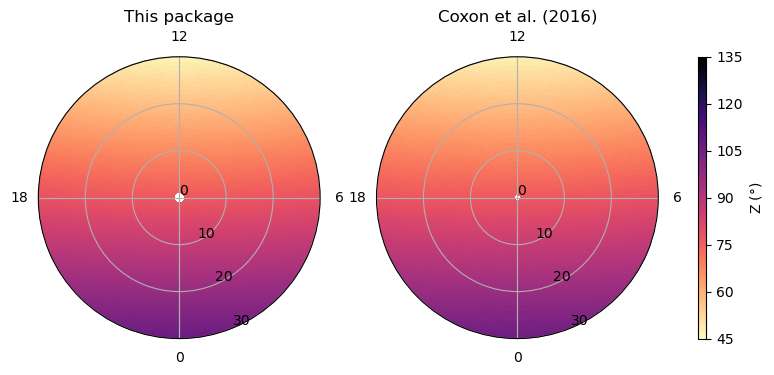

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0].set_title("This package")
ax[1].set_title("Coxon et al. (2016)")

for col, a in enumerate(ax):
    mesh[col] = models[col].map_solar_zenith_angle(ax[col], contours=False)

cax = models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"Z ($\degree$)")

## Compare $\Sigma_H$ and $\Sigma_P$

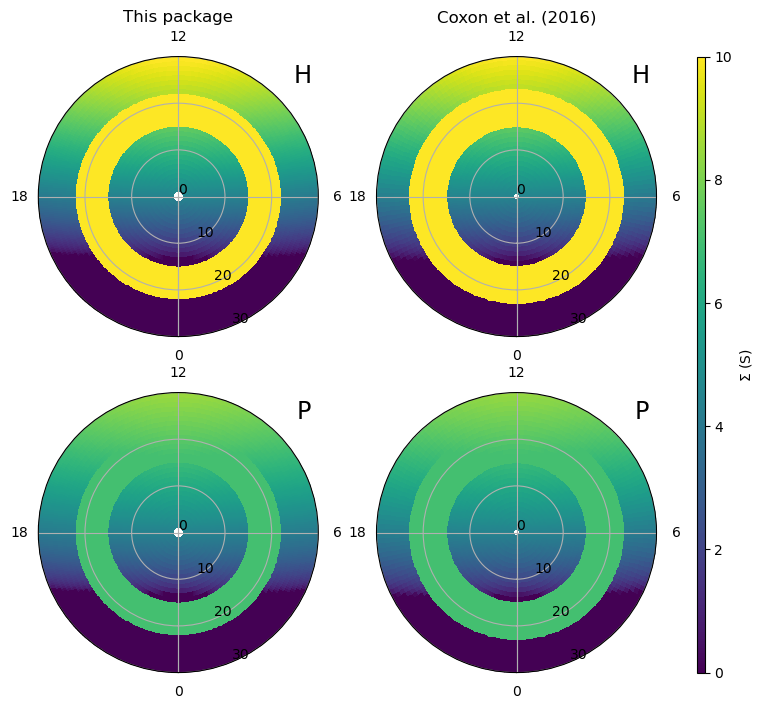

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0, 0].set_title("This package")
ax[0, 1].set_title("Coxon et al. (2016)")

components = ["hall", "pedersen"]

for row, ax_ in enumerate(ax):
    for col, a in enumerate(ax_):
        mesh[row, col] = models[col].map_sigma(a, components[row], contours=False)

cax = models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\Sigma$ (S)")

## Compare $\nabla.J_H$ and $\nabla.J_P$

This looks slightly different to the IDL code due to small changes in how the 

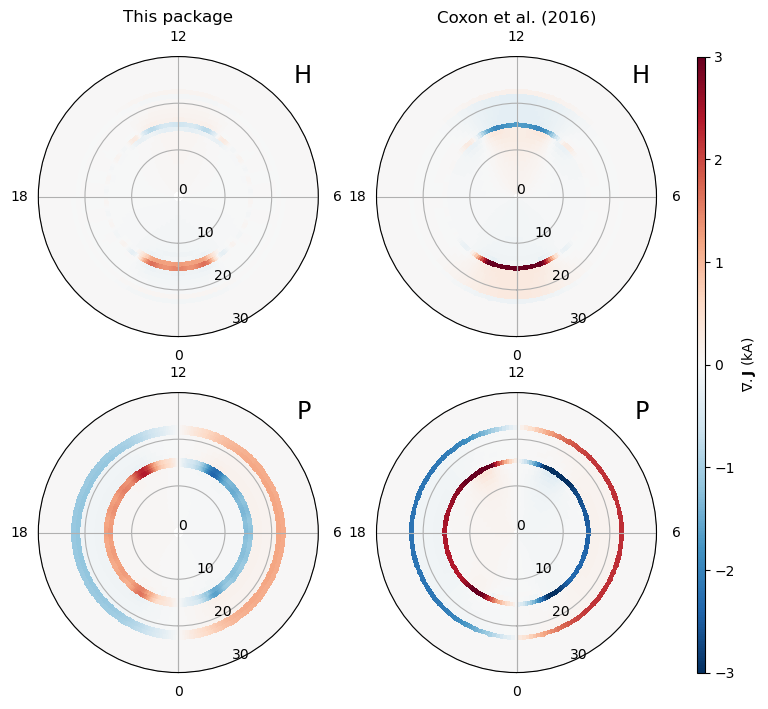

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0, 0].set_title("This package")
ax[0, 1].set_title("Coxon et al. (2016)")

components = ["hall", "pedersen"]

for row, ax_ in enumerate(ax):
    for col, a in enumerate(ax_):
        mesh[row, col] = models[col].map_div_j(a, components[row], contours=False)

cax = models[0].add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(7))
cbar.set_label(r"$\nabla.\mathbf{J}$ (kA)")